<a href="https://colab.research.google.com/github/Victor0vich/Denis/blob/main/Classification_EDA_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача классификации



Перед тем, как строить модели, хорошо бы понять, а как мы будем измерять качество их работы?

Мы с вами будем работать с задачей бинарной классификации, то есть возможных вариантов целевой переменной может быть всего 2. Для наглядности предположим, что предсказываем беременность.

В этом случае у нашего алгоритма может быть 4 варианта развития событий - предсказать беременность, когда она действительно есть, предсказать её отсутствие, когда её действительно нет, или совершить один из двух типов ошибок:

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

* Ошибка первого рода: мы предсказали человеку, что он беременен, а по факту нет.
* Ошибка второго рода: мы предсказали, что человек не беременен, а по факту - да.


![](https://miro.medium.com/max/3200/1*fSOPZZt8Bbm-lzNQhfqRLw.jpeg)



В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик.


### 1) Доля верно классифицированных объектов (Accuracy):

Берем всё, что предсказали правильно, делим на число всех наблюдений

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным.

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту.

### 2) Точность (Precision):

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку.

### 3) Полнота (Recall):

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение precision не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня False Positive. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

Давайте составим для алгоритма из первого пункта матрицу ошибок и подсчитаем эти две метркии. Под классом $1$ будем понимать больных. Именно их мы хотели бы найти.  


|          | $y=1$ | $y=0$ |
|----------|-------|-------|
|$a(x) = 1$|  0    |  0    |
|$a(x) = 0$|  50   |  950  |


Точность будет равна нулю. Полнота тоже. Мы видим насколько алгоритм никчёмен.

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, нам бы хотелось получить максимальную полноту. Не страшно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру:

### 4) F-measure:

$$F = \frac{1}{\beta\frac{1}{P} + (1 - \beta)\frac{1}{R}}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому.

Все эти метрики, конечно же, уже есть в пакете sklearn.

```python
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
```

# Задача классификации

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline
#plt.rcParams["figure.figsize"] = [8, 8]

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

# Реальные данные - реальная задача

[Предсказание ортопедических проблем](https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients#_=_) по измерениям костей таза и нижнего позвоночника. Быстро пройдемся по основным этапам работы с данными.

Загрузка - Статистики и Визуализация - Предобработка - Моделирование

In [ ]:
data = pd.read_csv('column_2C_weka.csv')

In [ ]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [ ]:
data['class'].unique()

array(['Abnormal', 'Normal'], dtype=object)

# EDA & Preprocessing

Прежде чем преступать к моделированию необходимо провести предварительное изучение данных (exploratory data analysis), чтобы выявить возможноные проблемы (пропуски, выбросы, категориальные переменные). А затем избавиться от проблем на этапе предобрабтки.

In [ ]:
data.describe()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [ ]:
data.isnull().sum()

pelvic_incidence            0
pelvic_tilt numeric         0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

## Распределение целевой переменной

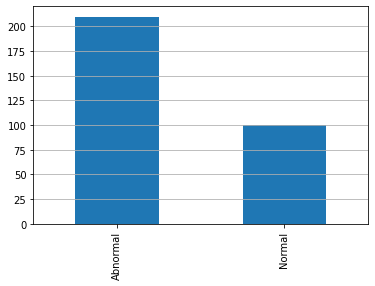

In [ ]:
data['class'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [ ]:
data['class'].value_counts(normalize=True)

Abnormal    0.677419
Normal      0.322581
Name: class, dtype: float64

Здесь же можно прикинуть наш **baseline** качества, с которым можно будет сравнивать результаты работы модели. Если у нас 68% одного класса и 32% другого, то даже если наша модель будет предсказывать сплошные `Abnormal`, то `accuracy` будет равна, в среднем, 68%.

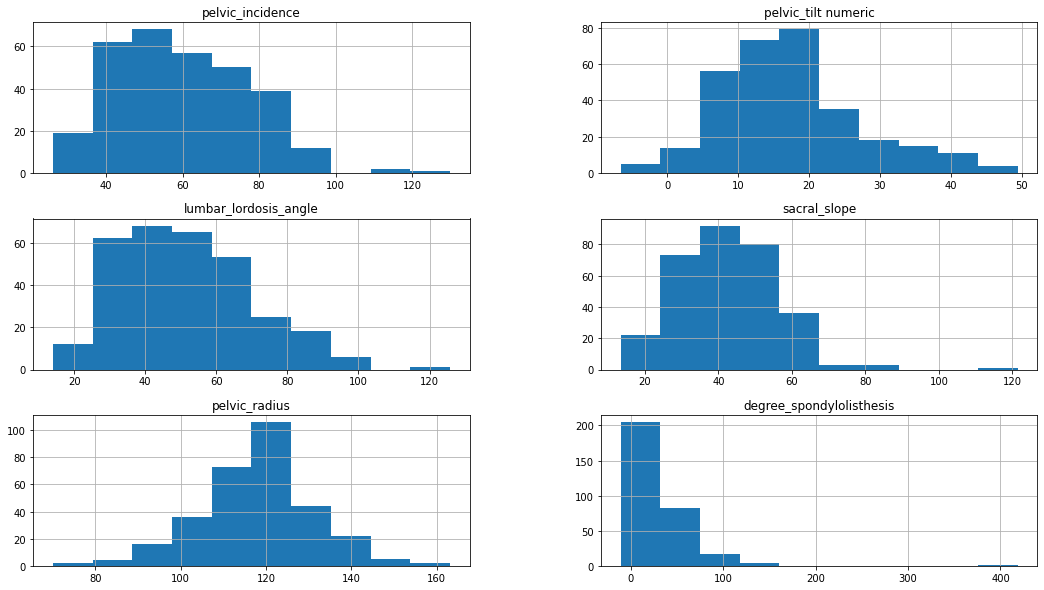

In [ ]:
data.hist(figsize=(18, 10));

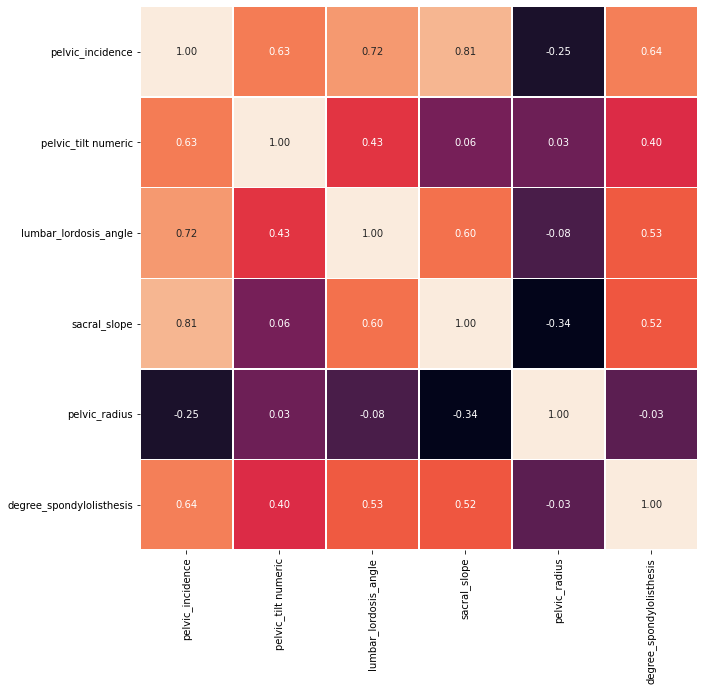

In [ ]:
#correlation map
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

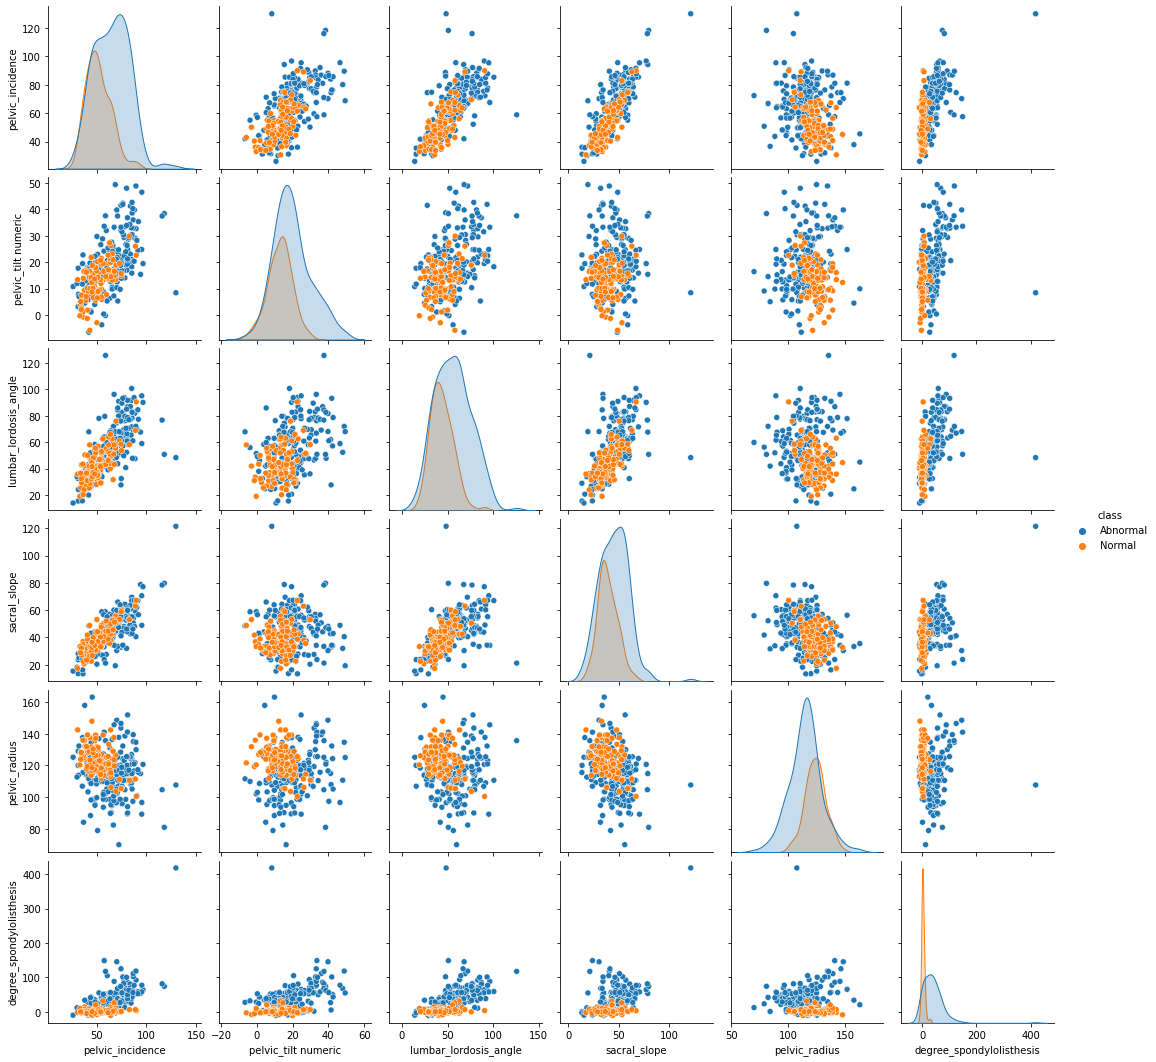

In [ ]:
sns.pairplot(data, hue='class');

## Перекодируем целевую

In [ ]:
data['class'] = data['class'].apply(lambda x: 1 if x=='Abnormal' else 0)

In [ ]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


# Выбор параметров модели

## Начинаем запутываться

**Testing set** - в самом начале работы откладываем часть данных и не используем их до внедрения модели в боевое окружение. Это наш финальный и самый верный способ проверить качество готовой модели.

**Training set** - используется для непосредственной тренировки модели, эти данные модель "видит" во время обучения

**Validation set** - этот набор даннных модель "не видит" во время тренировки, но мы его используем для настройки гиперпараметров, то есть проверяем качество обученной модели и если мы им недовольны - меняем параметры модели и повторяем процедуру. Таким образом, модель хоть напрямую с этими данными и не работает, информацию из них мы всё равно многократно используем и она просачивается в модель в виде настроенных параметров. Т.е., качество модели на валидационной выборке может быть завышено.


В `sklearn.model_selection` есть функция `train_test_split`, которая случайным (или не очень, если мы того хотим) образом делит выборку на две части. Вместо train и validation их чаще всего (на самом деле всегда) называют train и test, подразумевая, при этом, что истинная "тестовая" выборка хранится отдельно и будет использована в будущем после настройки модели.  

## Train-test split

Параметр `stratify` позволяет вам создавать такие разбиения, в которых распределения указанной переменной будут сохраняться. Очень полезно при дисбалансе классов, т.е. когда каких-то классов гораздо больше, чем других.

Попробуйте ответить, почему?

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['class'], axis=1), data['class'], test_size=0.20, random_state=5, stratify=data['class']
)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((248, 6), (62, 6), (248,), (62,))

In [ ]:
y_train.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

## Scaling
### Важно!
Учим на трейне - применяем на тесте. Практически все методы препроцессинга так или иначе используют информацию из выборки, например, при стандартизации считается среднее и дисперсия, значит, мы не хотим, чтобы информация из отложенной выборки просачивалась в тренировочную (data leak).

In [ ]:
from sklearn.preprocessing import StandardScaler
StandardScaler?

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# тоже самое другим кодом
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Подбор параметров разными способами

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

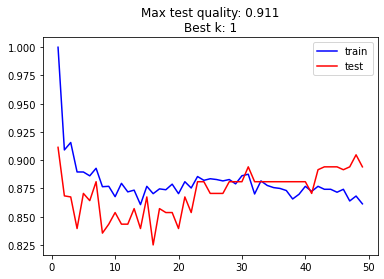

In [ ]:
neighbors = range(1, 50)
f1_score_train = []
f1_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    y_pred_train = knn.predict(X_train_scaled)
    f1_score_train.append(f1_score(y_pred_train, y_train))
    f1_score_test.append(f1_score(y_pred, y_test))

plt.plot(neighbors, f1_score_train, color='blue', label='train')
plt.plot(neighbors, f1_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
plt.legend();

## Кросс-валидация (k-fold cross-validation)

Иногда данных не то чтобы очень много, а потестировать модель всё же хочется, да и получить устойчивые и надежные оценки качества модели - тоже не так плохо.

Для такого случая была придумана очень полезная техника, использующася повсеместно - кросс-валидация. Наш изначальный датасет мы теперь будем делить не на train-validation-test, а на гораздо большее количество кусочков. В самом начале снова можно отложить тестовую выборку, на которой в самом конце мы проверим качество готовой модели. Далее берем оставшийся тренировочный датасет и делим его на папки (фолды, folds).

Например, задаём число фолдов равным 5. Теперь мы делим нашу тренировочную выборку на 5 равных кусков. На четырех их них обучаем модель, на шестом - меряем качество. Теперь берем другое сочетание фолдов и снова повторяем обучение/тестирование. Продолжаем, пока каждый из фолдов не поучаствовал в тестировании. Таким образом, мы получаем столько оценок качества, сколько изначально задали фолдов, и столько же раз нам пришлось нашу модель обучать и тестировать. Теперь эти оценки мы можем усреднить, посчитать стандартное отклонение и узнать как, в среднем, ошибается наша модель и какие интервалы у этой ошибки.

Вычислительно кросс-валидации крайне затратна, но если модель учится быстро, а датасет не сильно большой - это отличный способ получить "честные" оценки качества модели.

## GridSearchCV

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
        'n_neighbors': range(1, 50),
        'weights' : ['uniform', 'distance']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_neighbors)
)


test_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Resulting test score: {:.3f}".format(f1_score(test_predictions, y_test)))

Fitting 5 folds for each of 98 candidates, totalling 490 fits
Best CV score: 0.879, best CV k: 15
Resulting test score: 0.867
CPU times: user 2.09 s, sys: 15.6 ms, total: 2.11 s
Wall time: 2.1 s


In [ ]:
grid_search.best_estimator_.weights

'distance'

В презентацию.

## ROC-AUC

Оценим качество модели по метрике ROC-AUC.

Не забудьте, что для ROC-AUC нам нужны вероятности, поэтому вместо метода `predict` нужно использовать `predict_proba`.

In [ ]:
from sklearn.metrics import roc_auc_score
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict_proba(X_test_scaled)
roc_auc_score(y_test, y_pred[:,1])

### Дополнительные материалы:
- [Метод ближайших соседей](http://www.machinelearning.ru/wiki/index.php?title=Метод_ближайших_соседей)
- [Документация](http://scikit-learn.org/stable/modules/neighbors.html)sklearn по knn
- [Пример](https://www.kaggle.com/skalskip/iris-data-visualization-and-knn-classification) работы kNN на датасете Ирисов Фишера